In [4]:
import logging
from implicitml.calculator import ImplicitSolventCalculator, Solvent, Functional, BasisSet, SolventModel, logger
from implicitml.model import TinyModel
from implicitml.util import embedMolecule
from GNNImplicitSolvent import create_gnn_model, GNN3_Multisolvent_embedding_run_multiple_Delta, minimize_mol
from rdkit import Chem
from rdkit.Chem import AllChem
from Simulation.helper_functions import MODEL_PATH

In [5]:
import subprocess
result = subprocess.run(['orca', 'test.inp'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
lines = result.stdout.decode("utf-8")
for line in lines.split("\n"):
    if "Program" in line:
        print(line) 


                         Program Version 6.0.0  -   RELEASE  -


In [6]:
smiles = "COCCO"
from rdkit import Chem
from rdkit.Chem import AllChem
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol,randomSeed=42)

0

## Run an ORCA optimization in water

In [7]:
calc = ImplicitSolventCalculator(Chem.Mol(mol))
calc.optimize_orca(Solvent.WATER, Functional.BP86, BasisSet.def2_SVP, SolventModel.SMD, nprocs=1, maxcore=4096)

## Calculate single point energy of optimized geometry in water

In [8]:
calc.singlepoint(Solvent.WATER, Functional.BP86, BasisSet.def2_SVP, SolventModel.SMD, nprocs=1, maxcore=4096)
print(calc.electronic_energy)

-707234.0525001661


## Get the optimized molecule

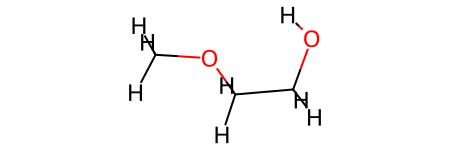

In [9]:
calc.molecule

## Calculate openCOSMO-RS free energy

In [10]:
calc.calculate_gibbs_free_energy(Solvent.WATER, Functional.BP86, BasisSet.def2_SVP, SolventModel.COSMORS, nprocs=1, maxcore=4096)
print(calc.gibbs_free_energy)

-707021.6053864663


## Optimize Structure with QM-GNNIS model

In [11]:
model = create_gnn_model(
    mol,
    solvent="tip3p",
    model_class=GNN3_Multisolvent_embedding_run_multiple_Delta,
    model_dict=MODEL_PATH,
    jit=False,
)

calc.optimize(Solvent.WATER, Functional.BP86, BasisSet.def2_SVP, SolventModel.CPCM, model=model, nprocs=1, maxcore=4096, fmax=0.025)

Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Calculating TORCH
      Step     Time          Energy          fmax
BFGS:    0 13:50:06    -7329.917416        0.278222
Calculating TORCH
BFGS:    1 13:50:11    -7329.919806        0.108929
Calculating TORCH
BFGS:    2 13:50:15    -7329.920072        0.045829
Calculating TORCH
BFGS:    3 13:50:20    -7329.920246        0.041485
Calculating TORCH
BFGS:    4 13:50:24    -7329.920586        0.039328
Calculating TORCH
BFGS:    5 13:50:29    -7329.920711        0.030288
Calculating TORCH
BFGS:    6 13:50:34    -7329.920837        0.025407
Calculating TORCH
BFGS:    7 13:50:38    -7329.920921        0.027579
Calculating TORCH
BFGS:    8 13:50:43    -7329.920989        0.024771


## Calculate Hessians

In [12]:
calc.calculate_hessian(Solvent.WATER, Functional.BP86, BasisSet.def2_SVP, SolventModel.CPCM, model=model, nprocs=1, maxcore=4096)
total_hessian = calc.QM_hessian*96.485332 + calc.GNN_hessian
print(total_hessian.shape)

Calculating TORCH
(39, 39)


## Calculate Vibrational Frequencies

In [13]:
from implicitml.util import normal_modes
from Simulation.helper_functions import calculate_entropy_from_frequencies
import numpy as np

In [14]:
masses = np.array([atom.GetMass() for atom in calc.molecule.GetAtoms()]).round(0)
indices = [atom.GetIdx() for atom in calc.molecule.GetAtoms()]
freqs, modes = normal_modes(total_hessian, indices,masses)

freqs

array([  74.64182565+0.j,  102.57678144+0.j,  215.32203248+0.j,
        267.00892009+0.j,  337.87876091+0.j,  383.5771921 +0.j,
        533.9938578 +0.j,  820.92450071+0.j,  887.11480731+0.j,
       1001.10898256+0.j, 1054.29585599+0.j, 1084.81657967+0.j,
       1129.33310218+0.j, 1136.14467864+0.j, 1151.61127226+0.j,
       1204.3419524 +0.j, 1218.91148235+0.j, 1323.88397777+0.j,
       1337.48539383+0.j, 1379.56114512+0.j, 1386.13355992+0.j,
       1397.44810973+0.j, 1412.38221442+0.j, 1414.69020063+0.j,
       1439.63168075+0.j, 2989.28329511+0.j, 3116.0350778 +0.j,
       3140.990548  +0.j, 3239.41441438+0.j, 3272.94754611+0.j,
       3316.01275895+0.j, 3340.11329304+0.j, 3662.88230932+0.j])

## Calculate free energy of QM-GNNIS model

In [15]:
entropy = calculate_entropy_from_frequencies(freqs)
calc.singlepoint(Solvent.WATER, Functional.BP86, BasisSet.def2_SVP, SolventModel.CPCM, model=model, nprocs=1, maxcore=4096)
energy = calc.electronic_energy
gibbs_free_energy = energy - entropy
gibbs_free_energy

Calculating TORCH


-707247.432606336909